In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import catboost as cb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance


### Pre-processing for CatBoost

In [23]:
df = pd.read_csv('data.csv')
df.head()

,A53_M5_3007 (Belegungen/Intervall),D11 (Belegungen/Intervall),D12 (Belegungen/Intervall),D21 (Belegungen/Intervall),D31 (Belegungen/Intervall),D41 (Belegungen/Intervall),D42 (Belegungen/Intervall),H53_M3_3006 (Belegungen/Intervall),H53_M6_1140 (Belegungen/Intervall),H57_M1_1137 (Belegungen/Intervall),Date,Time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-06,00:00:00
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2021-01-06,00:01:00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-06,00:02:00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-06,00:03:00
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2021-01-06,00:04:00


#### Creating one single DateTime column and taking hourly_average of data

In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Datetime', inplace=True)
hourly_sum = df.resample('H').sum()

In [25]:
hourly_sum.reset_index(inplace=True)
#hourly_sum['Date'] = hourly_sum['Datetime'].dt.date
#hourly_sum['Time'] = hourly_sum['Datetime'].dt.time

# Drop the 'Datetime'
#hourly_sum.drop(columns=['Datetime'], inplace=True)
hourly_sum.fillna(0, inplace=True)
hourly_sum.head()

,Datetime,A53_M5_3007 (Belegungen/Intervall),D11 (Belegungen/Intervall),D12 (Belegungen/Intervall),D21 (Belegungen/Intervall),D31 (Belegungen/Intervall),D41 (Belegungen/Intervall),D42 (Belegungen/Intervall),H53_M3_3006 (Belegungen/Intervall),H53_M6_1140 (Belegungen/Intervall),H57_M1_1137 (Belegungen/Intervall)
0,2021-01-06 00:00:00,12.0,5.0,3.0,2.0,0.0,9.0,35.0,8.0,0.0,8.0
1,2021-01-06 01:00:00,2.0,2.0,7.0,0.0,0.0,4.0,35.0,4.0,0.0,4.0
2,2021-01-06 02:00:00,0.0,2.0,3.0,0.0,0.0,3.0,22.0,0.0,0.0,0.0
3,2021-01-06 03:00:00,3.0,1.0,1.0,1.0,0.0,3.0,18.0,2.0,0.0,2.0
4,2021-01-06 04:00:00,6.0,4.0,3.0,3.0,0.0,7.0,28.0,9.0,0.0,9.0


#### Speficying the time-series column and perform test-train split

In [26]:
hourly_sum['Year'] = hourly_sum['Datetime'].dt.year
hourly_sum['Month'] = hourly_sum['Datetime'].dt.month
hourly_sum['Day'] = hourly_sum['Datetime'].dt.day
hourly_sum['Hour'] = hourly_sum['Datetime'].dt.hour

In [27]:
X = hourly_sum[['A53_M5_3007 (Belegungen/Intervall)', 'Year', 'Month', 'Day', 'Hour']]
y = hourly_sum['D11 (Belegungen/Intervall)']

# test_size: Fraction of the data to reserve as the test set
# random_state: Seed for random number generator for reproducibility

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# transform dataset into catBoost Pool class (internal data format)
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

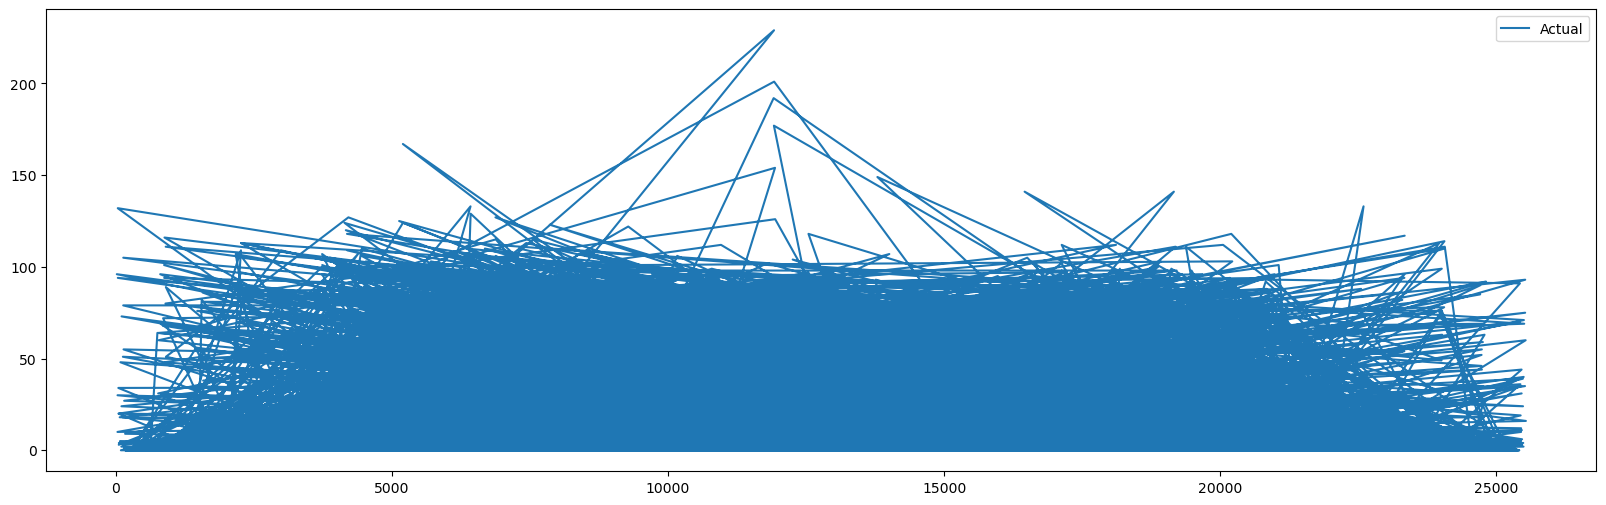

In [28]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Actual')
#plt.plot(pred, label='Predicted')
plt.legend()
plt.show()

### Model Training

In [29]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
# use grid search to find best parameters
#grid = {'iterations': [100, 150, 200],
#        'learning_rate': [0.03, 0.1],
#        'depth': [2, 4, 6, 8],
#        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
#model.grid_search(grid, train_dataset)

model.fit(train_dataset,
          plot=True)

In [32]:
pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

y_test = np.where(y_test == 0, 1e-100, y_test)
mean_actual = sum(y_test) / len(y_test)  # Calculate the mean of actual values
mae_percentage = (mae / mean_actual) * 100

# SMAPE
smape_score = 100/len(y_test) * np.sum(2 * np.abs(pred - y_test) / (np.abs(pred) + np.abs(y_test)))

print("Testing performance")
print('MAE: {:.2f}'.format(mae))
print('MAE percentage: {:.2f}'.format(mae_percentage))
print('MSE: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))
print(f"SMAPE Score: {smape_score:.2f}%")

Testing performance
MAE: 4.10
MAE percentage: 17.93
MSE: 60.27
RMSE: 7.76
R2: 0.94
SMAPE Score: 102.72%


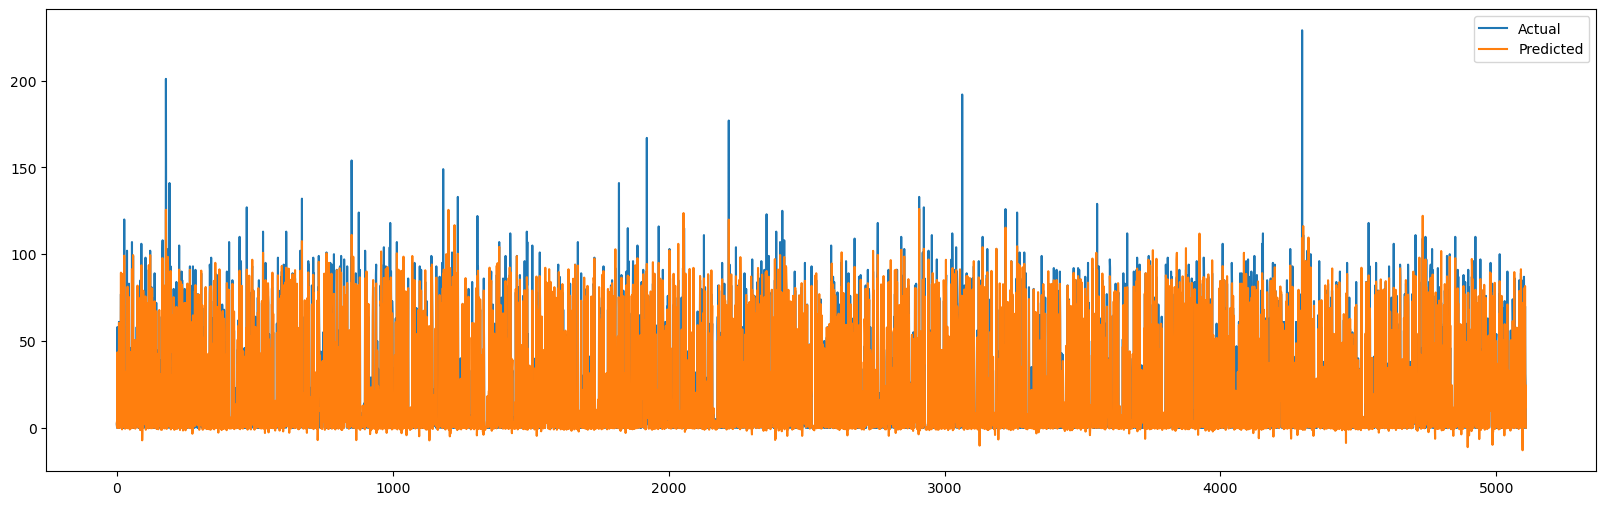

In [33]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.show()